In [2]:
# install datasets
!pip3 install datasets unidecode ipywidgets tqdm

# Make sure that we have a recent version of pyarrow in the session before we continue - otherwise reboot Colab to activate it
import pyarrow
if int(pyarrow.__version__.split('.')[1]) < 16 and int(pyarrow.__version__.split('.')[0]) == 0:
    import os
    os.kill(os.getpid(), 9)

from datasets import load_dataset
from pprint import pprint
from tqdm import tqdm
import numpy as np
from unidecode import unidecode
import re
import scipy.sparse
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from cb91visuals import *

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
# Checks if ppmi matrix was saved to disk

if os.path.exists('capes_ppmi.npy'):
  print("Loading ppmi matrix from disk...")
  sparse_ppmi = scipy.sparse.load_npz('capes_ppmi.npy')
else:
  dataset = load_dataset('capes')
  pprint(dataset)

  texts = []

  print("Pre-processing dataset...")
  def process_text(text):
    txt = unidecode(text).replace('\n' , '') # Normalizes string
    txt = re.sub(r"\([^()]*\)", "", txt) # Removes everything inside parenthesis
    txt = re.sub(r'\w*\d\w*', ' ', txt).strip() # Remove numbers
    txt = re.sub(r'[^a-zA-Z0-9]', ' ', txt) # Removes all non-alphanumeric characters
    txt = re.sub(r"\s{2,}", ' ', txt).strip() # Removes double or more spaces
    return txt

  for text in tqdm(dataset['train']['translation']):
    texts.append(process_text(text['pt']))

  MAX_WORD_SIZE = 28
  MIN_FREQ = 70

  def iterate_dataset(window_size, word_fn, *args):
    for text in tqdm(texts):
      words = text.split(" ")
      for i in range(len(words)):
        word = words[i]

        if len(word) > MAX_WORD_SIZE:
          continue

        for j in range(-window_size, window_size):
          if j + i >= 0 and j + i < len(words):
            if not word_fn is None and len(words[j+i]) <= MAX_WORD_SIZE:
              word_fn(word, words[j + i], *args)

  def word_map_create_fn(word, context, words_map, words_count):
    if not word in words_map:
      words_map[word] = len(words_map)
      words_count[word] = 0
    
    words_count[word] += 1

  def freq_ctx_fn(word, context, words_map, freq_matrix):
    if word in words_map and context in words_map:
      freq_matrix[words_map[word], words_map[context]] += 1

  def create_freq_matrix(window_size):
    words_map = {}
    words_count = {}

    print("Creating word map...")
    iterate_dataset(window_size,
                    word_map_create_fn,
                    words_map, words_count)
    
    # Remove words that are not frequent enough
    for word, freq in words_count.items():
      if freq < MIN_FREQ:
        if word in words_map:
          del words_map[word]

    # Adjusts the word map indices
    words = []
    i = 0
    for w in words_map:
      words_map[w] = i
      words.append(w)
      i += 1

    print("Vocab size:", len(words_map))
    
    # Creates the frequency matrix
    print("Allocating frequency matrix: {:.2f} GB".format((len(words_map) * len(words_map)) * 2 / (1000 ** 3)))
    freq_matrix = np.zeros((len(words_map), len(words_map)), dtype=np.float32)

    print("Creating frequency matrix...")
    iterate_dataset(window_size, freq_ctx_fn, words_map, freq_matrix)
    return freq_matrix, words

  freq_matrix, words = create_freq_matrix(window_size=2)

  def create_ppmi_matrix(freq_matrix, positive=True):
    total = freq_matrix.sum()
    word_counts = np.sum(freq_matrix, axis=1)
    context_counts = np.sum(freq_matrix, axis=0)

    expected = np.outer(word_counts, context_counts) / total
    freq_matrix = freq_matrix / expected

    with np.errstate(divide='ignore'):
      freq_matrix = np.log(freq_matrix)

    freq_matrix[np.isinf(freq_matrix)] = 0.0

    if positive:
      freq_matrix[freq_matrix < 0] = 0.0

    return freq_matrix

  ppmi = create_ppmi_matrix(freq_matrix)
  sparse_ppmi = scipy.sparse.coo_matrix(ppmi)
  scipy.sparse.save_npz('capes_ppmi.npz', sparse_ppmi)

Reusing dataset capes (/home/Pedro/.cache/huggingface/datasets/capes/en-pt/1.0.0/b2c08eed67d23b54883a184eb830ecc54bc1cb7f7e4527ee45586ef5bbd0cc8f)


  0%|          | 0/1 [00:00<?, ?it/s]

{'train': Dataset({
    features: ['translation'],
    num_rows: 1157610
})}


In [21]:
import jax
import jax.numpy as jnp
import numpy as np
from sklearn.utils.extmath import randomized_svd

jax.config.update('jax_platform_name', 'cpu') # Not enough memory to run on the TPU

U, Sigma, VT = randomized_svd(sparse_ppmi, 
                              n_components=128,
                              n_iter=8,
                              random_state=None)

In [53]:
W = np.dot(U, np.diag(np.sqrt(Sigma)))

words_map = {}

for i in range(len(words)):
    words_map[words[i]] = i

def get_embedding(word):
    if word in words_map:
        return W[words_map[word],]
    else:
        return np.zeros(128)

def get_embeddings(words):
    return np.array([get_embedding(word) for word in words])

def get_closest_words(embedding, count):
    distances = np.linalg.norm(W - embedding, axis=1)
    return np.asarray(words, dtype=np.str)[np.argsort(distances)[:count]]

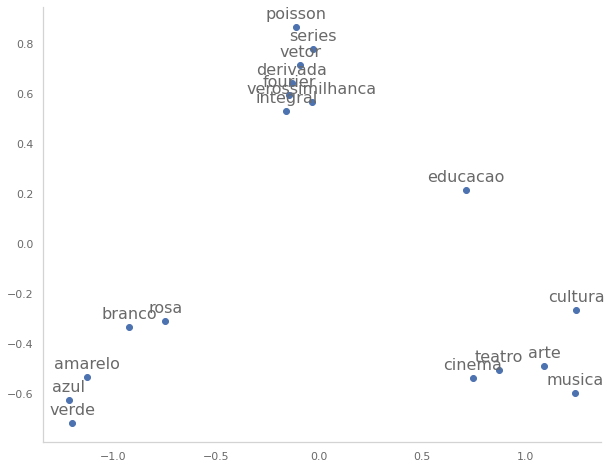

In [95]:
words_to_plot = [ 'azul', 'amarelo', 'branco', 'cultura', 'arte', 'educacao', 'musica', 'teatro',
                  'cinema', 'verde', 'rosa', 'integral', 'derivada', 'vetor', 'fourier',
                  'series', 'verossimilhanca', 'poisson' ]

plt.rcParams['figure.figsize'] = (10, 8)

pca = PCA(n_components=2)
X = pca.fit_transform(get_embeddings(words_to_plot))
plt.scatter(x=X[:,0], y=X[:,1])
 
# Inserts labels to the plot
for i in range(len(words_to_plot)):
    plt.text(X[i, 0], X[i, 1] + 0.05, words_to_plot[i], ha='center', va='center')

In [82]:
get_closest_words(get_embedding('amor'), 10)

array(['amor', 'felicidade', 'desejo', 'solidao', 'deus', 'afeto',
       'espiritualidade', 'alma', 'mito', 'erotismo'], dtype='<U27')

In [83]:
get_closest_words(get_embedding('navio'), 10)

array(['navio', 'trilho', 'pente', 'megaevento', 'combustor',
       'aldeamento', 'aerogerador', 'subjetivismo', 'vestido',
       'esquizofrenico'], dtype='<U27')